In [1]:
#run pip install fancyimpute
#launch spark 
import pyspark
import dxpy
import dxdata
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import stats
from fancyimpute import IterativeImputer
from scipy.stats import chi2_contingency
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/cluster/dnax/jars/dnanexus-api-0.1.0-SNAPSHOT-jar-with-dependencies.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/cluster/spark/jars/log4j-slf4j-impl-2.17.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2023-09-18 02:33:01.287 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2023-09-18 02:33:02.369 WARN  Utils:69 - Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 43000. Attempting port 43001.
2023-09-18 02:33:02.608 WARN  MetricsReporter:84 - No metrics configured for reporting
2023-09-18 02:33:02.609 WARN  LineProtoUsageReporter:48 - Telegraf configurations: url [metrics.push.telegraf.hostport], user [metrics.push.telegraf.user] or password [metrics.push.telegraf.password] missing.
2023-09-18 02:33:02.610 WARN  MetricsReporter:117 - metrics.scraping.httpserver.port


In [2]:
#prep database 
dispensed_database_name = dxpy.find_one_data_object(classname="database", name="app*", folder="/", name_mode="glob", describe=True)["describe"]["name"]
dispensed_dataset_id = dxpy.find_one_data_object(typename="Dataset", name="app*.dataset", folder="/", name_mode="glob")["id"]

In [3]:
#prep dataset
dataset = dxdata.load_dataset(id=dispensed_dataset_id)
participant = dataset["participant"]

In [4]:
#pull all relevant columns
field_names = ["eid", "p31", "p22189", "p21000_i0", "p21001_i0", 'p21001_i1', 'p21003_i0',  'p21003_i1', "p1558_i0","p1558_i1", "p20002_i0",  "p131298", "p6150_i0", "p131286", "p131294", "p130814", "p130706", "p130708", "p53_i0",  "p53_i1",  "p130892", "p130894", "p130896", "p2050_i0", "p2060_i0",  "p2050_i1",  "p130838", "p131056", "p131058", "p131180", "p131360", "p131362", "p131364", "p131366", "p131368", "p131370", "p131372", "p131374", "p131376", "p131378", "p22032_i0", 'p21001_i1', 'p1558_i1', 'p21003_i1',  'p21003_i1', 'p20116_i0', 'p20116_i1', 'p20003_i0', 'p1160_i0', 'p20003_i1', 'p1160_i1', 'p1070_i0', 'p1070_i1', 'p1080_i0', 'p1080_i1', 'p1120_i0', 'p1120_i1', 'p110005', 'p90051' , 'p90016', 'p90017', 'p90185', 'p90187', 'p90012', 'p90010', 'p90011', 'p6142_i0' , 'p134_i0', 'p131354', 'p131306', 'p40046_i0', 'p40047_i0', 'p40048_i0', 'p40049_i0', 'p90027', 'p90028', 'p90029', 'p90030', 'p90031', 'p90032', 'p90033', 'p90034', 'p90035', 'p90036', 'p90037', 'p90038', 'p90039', 'p90040', 'p90041', 'p90042', 'p90043', 'p90044', 'p90045', 'p90046', 'p90047', 'p90048', 'p90049', 'p90050', 'p90051', 'p40030_i0', 'p40031_i0', 'p40032_i0', 'p40033_i0', 'p6146_i0']
df = participant.retrieve_fields(names=field_names, engine=dxdata.connect())

2023-09-18 02:33:13.900 WARN  ShellBasedUnixGroupsMapping:210 - unable to return groups for user pQgXFYVQy25Yk5kKPgYB9pJ2z5qgXPJpBjPXZkgf__project-GG7jpPjJ4VK0VKqV89494XV5
PartialGroupNameException The user name 'pQgXFYVQy25Yk5kKPgYB9pJ2z5qgXPJpBjPXZkgf__project-GG7jpPjJ4VK0VKqV89494XV5' is not found. id: ‘pQgXFYVQy25Yk5kKPgYB9pJ2z5qgXPJpBjPXZkgf__project-GG7jpPjJ4VK0VKqV89494XV5’: no such user
id: ‘pQgXFYVQy25Yk5kKPgYB9pJ2z5qgXPJpBjPXZkgf__project-GG7jpPjJ4VK0VKqV89494XV5’: no such user

	at org.apache.hadoop.security.ShellBasedUnixGroupsMapping.resolvePartialGroupNames(ShellBasedUnixGroupsMapping.java:294)
	at org.apache.hadoop.security.ShellBasedUnixGroupsMapping.getUnixGroups(ShellBasedUnixGroupsMapping.java:207)
	at org.apache.hadoop.security.ShellBasedUnixGroupsMapping.getGroups(ShellBasedUnixGroupsMapping.java:97)
	at org.apache.hadoop.security.JniBasedUnixGroupsMappingWithFallback.getGroups(JniBasedUnixGroupsMappingWithFallback.java:51)
	at org.apache.hadoop.security.Groups$Gro

In [5]:
#create pandas dataframe
pdf = df.toPandas()

2023-09-18 02:33:44.730 WARN  package:69 - Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


/cluster/spark/python/pyspark/sql/pandas/conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/cluster/spark/python/pyspark/sql/pandas/conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [6]:
#check that pandas conversion worked - this is the full UKBB rows of px
#pdf.head(10)
len(pdf)

502364

In [7]:
#drop any row/participant who does not have lifestyle data
#pdf_lifestyle = pdf.dropna(subset=['p20116_i0',  'p1558_i0', 'p1160_i0', 'p1070_i0', 'p1080_i0', 'p1120_i0', 'p2050_i0'])
#drop any row/participant who does not have wear duration data, aka accelerometer data
pdf_lifestyle = pdf.dropna(subset=['p90051'])
#check DF length
len(pdf_lifestyle)

103660

In [8]:
#accelerometer cohort and quality control below

In [9]:
pdf_lifestyle = pdf[pdf['p90051'] >= 3.0]
print('after dropping px with less than 72 hours of wear time', len(pdf_lifestyle))

after dropping px with less than 72 hours of wear time 97123


In [10]:
pdf_lifestyle = pdf_lifestyle[pdf_lifestyle['p90016'] == 1]
print('after dropping px with poor calibration (outer)', len(pdf_lifestyle))

after dropping px with poor calibration (outer) 97119


In [11]:
pdf_lifestyle = pdf_lifestyle[pdf_lifestyle['p90017'] == 1]
print('after dropping px with poor calibration (self)', len(pdf_lifestyle))

after dropping px with poor calibration (self) 96956


In [12]:
pdf_lifestyle['clip_perc'] = pdf_lifestyle['p90185']/pdf_lifestyle['p90187']
pdf_lifestyle['clip_perc'].head(10)
pdf_lifestyle = pdf_lifestyle[pdf_lifestyle['clip_perc'] <= 0.01]
print('after dropping px with more than 1% clips', len(pdf_lifestyle))

after dropping px with more than 1% clips 96956


In [13]:
pdf_lifestyle = pdf_lifestyle[pdf_lifestyle['p90012'] <= 100]
print('after dropping px with avg acceleration > 100 mg', len(pdf_lifestyle))

after dropping px with avg acceleration > 100 mg 96949


In [14]:
#accelerometer quality check completed

In [15]:
#rename columns
pdf_rename = pdf_lifestyle.rename(columns={'eid': 'pID', 'p31': 'male', 'p22189': 'tdi', 'p21000_i0': 'ethnicity', 'p21001_i0': 'bmi', 'p21001_i1': 'bmi_1', 'p1558_i0': 'alc_freq', 'p1558_i1': 'alc_freq_1', 'p20002_i0': 'sr_illness', 'p21003_i0': 'age_i0', 'p21003_i1': 'age_i1',  'p131298': 'i21_date', 'p6150_i0': 'vasc_diag', 'p131298': 'i21_date', 'p131286': 'i10_date', 'p131294': 'i15_date', 'p130814': 'e78_date', 'p130706': 'e10_date', 'p130708': 'e11_date', 'p53_i0': 'date_i0', 'p53_i1': 'date_i1', 'p41271': 'icd9', 'p41270': 'icd10', 'p130892': 'f31_date',  'p130894': 'f32_date', 'p130896': 'f33_date', 'p2050_i0': 'phq2_1', 'p130838': 'f01_date', 'p131056': 'g45_date', 'p131058': 'g46_date', 'p131180': 'h34_date', 'p131360': 'i60_date', 'p131362': 'i61_date', 'p131364': 'i62_date', 'p131366': 'i63_date', 'p131368': 'i64_date', 'p131370': 'i65_date', 'p131372': 'i66_date', 'p131374': 'i67_date', 'p131376': 'i68_date', 'p131378': 'i69_date', 'p20116_i0': 'smok_stat', "p20116_i1": 'smok_stat_1', 'p1160_i0': 'sleep', 'p1160_i1': 'sleep_1', 'p1070_i0':'tv', 'p1070_i1':'tv_1', 'p1080_i0':'computer', 'p1080_i1':'computer_1', 'p1120_i0': 'mobile phone', 'p1120_i1': 'mobile phone_1', 'p20510': 'phq2_1_1', 'p22032_i0': 'ipaq', 'p2050_i1': 'phq2_1_followup', 'p90012': 'aac_overall_avg', 'p90185': 'acc_exceed8g_aftercal', 'p90187': 'acc_total_data_read', 'p90017': 'acc_calib_own', 'p90016': 'acc_calib_all', 'p90051': 'acc_weartime', 'p90010': 'acc_start_date', 'p90011': 'acc_end_date', 'p6142_i0': 'employ_status',  'p131354': 'i50_date', 'p131306': 'i25_date', 'p40046_i0': 'pa_sleep_over_avg', 'p40047_i0': 'pa_seden_over_avg', 'p40048_i0': 'pa_light_over_avg',  'p40049_i0': 'pa_mv_over_avg', 'p40049_i0': 'pa_mv_over_avg', 'p90027':'pa_time_1', 'p90028':'pa_time_2', 'p90029':'pa_time_3', 'p90030':'pa_time_4', 'p90031':'pa_time_5', 'p90032':'pa_time_6', 'p90033':'pa_time_7', 'p90034':'pa_time_8', 'p90035':'pa_time_9', 'p90036':'pa_time_10', 'p90037':'pa_time_11', 'p90038':'pa_time_12', 'p90039':'pa_time_13', 'p90040':'pa_time_14', 'p90041':'pa_time_15', 'p90042':'pa_time_16', 'p90043':'pa_time_17', 'p90044':'pa_time_18', 'p90045':'pa_time_19', 'p90046':'pa_time_20', 'p90047':'pa_time_21', 'p90048':'pa_time_22', 'p90049':'pa_time_23', 'p90050':'pa_time_24', 'p90051': 'pa_sum_wear', 'p40030_i0': 'pa_sleep_day_hour', 'p40031_i0': 'pa_sed_day_hour', 'p40032_i0': 'pa_light_day_hour', 'p40033_i0': 'pa_mv_day_hour', 'p6146_i0': 'gov_assistance'})
#check that rename worked
pdf_rename.head(5)

,pID,male,tdi,ethnicity,bmi,bmi_1,age_i0,age_i1,alc_freq,alc_freq_1,...,pa_time_21,pa_time_22,pa_time_23,pa_time_24,pa_sleep_day_hour,pa_sed_day_hour,pa_light_day_hour,pa_mv_day_hour,gov_assistance,clip_perc
0,5545411,1,-4.62,1001.0,28.8906,NaN,59,NaN,3.0,NaN,...,9.82,15.90,15.48,8.51,"0.96,0.97,0.95,0.96,1,1,0.95,0.57,0.17,0.07,0,...","0.01,0.03,0.05,0.04,0,0,0.01,0.34,0.62,0.45,0....","0.03,0,0,0,0,0,0.04,0.09,0.21,0.35,0.33,0.22,0...","0,0,0,0,0,0,0,0,0,0.13,0.15,0.34,0.16,0,0.02,0...",[-7],3.292736e-05
1,5180517,0,-0.42,1001.0,22.7933,NaN,52,NaN,5.0,NaN,...,33.53,28.41,31.26,32.41,"0.98,1,1,1,1,1,1,0.44,0.02,0.14,0,0,0.04,0.12,...","0.02,0,0,0,0,0,0,0.46,0.52,0.22,0.28,0.33,0.5,...","0,0,0,0,0,0,0,0.11,0.46,0.58,0.57,0.57,0.35,0....","0,0,0,0,0,0,0,0,0,0.05,0.15,0.1,0.1,0.13,0.07,...",[-7],3.599349e-06
8,3530112,0,-2.74,1001.0,26.6137,NaN,52,NaN,5.0,NaN,...,18.45,14.58,7.09,3.58,"1,0.99,1,1,1,0.85,0.34,0.47,0.1,0,0,0,0,0,0,0,...","0,0.01,0,0,0,0.03,0.15,0.07,0.15,0.08,0.05,0.4...","0,0,0,0,0,0.11,0.29,0.46,0.75,0.87,0.78,0.56,0...","0,0,0,0,0,0,0.22,0,0,0.06,0.18,0.04,0,0.02,0.0...",[-7],5.219251e-06
11,3176117,0,-0.36,1001.0,20.0918,NaN,50,NaN,2.0,NaN,...,32.56,38.86,36.33,29.51,"0.47,0.5,0.45,0.4,0.51,0.44,0.4,0.43,0.46,0.43...","0.19,0.23,0.35,0.25,0.27,0.18,0.1,0.06,0.12,0....","0.28,0.18,0.2,0.31,0.22,0.39,0.5,0.5,0.4,0.19,...","0.06,0.08,0,0.04,0,0,0,0,0.02,0.04,0,0,0.02,0....",[-7],4.263014e-06
13,3429176,0,-1.93,3001.0,23.2577,NaN,47,NaN,3.0,NaN,...,39.91,22.84,12.52,18.10,"0.73,1,1,1,1,0.98,0.88,0.84,0.66,0.2,0.14,0.05...","0.09,0,0,0,0,0,0,0.11,0.18,0.36,0.42,0.32,0.31...","0.18,0,0,0,0,0.02,0.12,0.05,0.16,0.44,0.45,0.6...","0,0,0,0,0,0,0,0,0,0,0,0,0.14,0.01,0.02,0.04,0....",[-7],9.191687e-07


In [16]:
#check that rename worked
pdf_rename['pa_time_1'].head(5)

0      4.66
1      2.15
8      5.36
11    30.74
13    11.81
Name: pa_time_1, dtype: float64

In [17]:
#convert physical activity (pa) data to numeric
pdf_rename['pa_sum_wear'] = pd.to_numeric(pdf_rename['pa_sum_wear'], errors='coerce')
pdf_rename['pa_seden_over_avg'] = pd.to_numeric(pdf_rename['pa_seden_over_avg'], errors='coerce')
pdf_rename['pa_sleep_over_avg'] = pd.to_numeric(pdf_rename['pa_sleep_over_avg'], errors='coerce')
pdf_rename['pa_light_over_avg'] = pd.to_numeric(pdf_rename['pa_light_over_avg'], errors='coerce')
pdf_rename['pa_mv_over_avg'] = pd.to_numeric(pdf_rename['pa_mv_over_avg'], errors='coerce')
#; convert total wear value/day to minutes
pdf_rename['pa_sum_wear_min'] = pdf_rename['pa_sum_wear']*24*60
#convert PA type to minutes/day/week = daily minutes in PA type
pdf_rename['pa_sed_convert'] = (pdf_rename['pa_sum_wear_min']*pdf_rename['pa_seden_over_avg'])/pdf_rename['pa_sum_wear']
pdf_rename['pa_sleep_convert'] = (pdf_rename['pa_sum_wear_min']*pdf_rename['pa_sleep_over_avg'])/pdf_rename['pa_sum_wear']
pdf_rename['pa_light_convert'] = (pdf_rename['pa_sum_wear_min']*pdf_rename['pa_light_over_avg'])/pdf_rename['pa_sum_wear']
pdf_rename['pa_mv_convert'] = (pdf_rename['pa_sum_wear_min']*pdf_rename['pa_mv_over_avg'])/pdf_rename['pa_sum_wear']
#check conversion
pdf_rename['pa_sleep_convert'].head(4)

0     584.0208
1     475.6176
8     603.6336
11    442.9296
Name: pa_sleep_convert, dtype: float64

In [18]:
#convert ethnicity data to be workable
pdf_rename['ethnicity'].dtype
pdf_rename['ethnicity'] = pd.to_numeric(pdf_rename['ethnicity'], errors='coerce')
pdf_rename['ethnicity'].dtype
for index, row in pdf_rename.iterrows():
    if row['ethnicity'] == 1.0 or row['ethnicity'] == 1001.0 or row['ethnicity'] == 1002.0 or row['ethnicity'] == 1003.0:
        pdf_rename.at[index, 'white_yes'] = 1

In [19]:
#create 4 seasons of accelerometer wear using accelerometer wear start date
def filter_accwear_month(date):
    if date.month in [12, 1, 2]:
        return 1
    elif date.month in [3, 4, 5]:
        return 2
    elif date.month in [6, 7, 8]:
        return 3
    else:
        return 4  

pdf_rename['acc_wearmonth'] = pdf_rename['acc_start_date'].apply(filter_accwear_month)

In [20]:
#drop -1 ("do not know") and -3 ("prefer not to answer") from sleep duration survey
pdf_rename = pdf_rename[~(pdf_rename['sleep'] == -3)]
pdf_rename = pdf_rename[~(pdf_rename['sleep'] == -1)]
print('after dropping px with missing sleep survey data', len(pdf_rename))

after dropping px with missing sleep survey data 96703


In [21]:
#clean employment survey arrays
pdf_rename['employ_status'].head(10)
pdf_rename['employ_status'].dtype
def employ_array(lst):
    if isinstance(lst, list):
        return np.array(lst)
    else:
        return None 

pdf_rename['employ_status_array'] = pdf_rename['employ_status'].apply(employ_array)

In [22]:
#continue cleaning employment covariate
pdf_rename['employ_status_array'].head(10)
pdf_rename['employ_status_array'].dtype
#drop missing survey data/chose not to respond
pdf_rename = pdf_rename[~(pdf_rename['employ_status'] == -3)]
pdf_rename = pdf_rename[~(pdf_rename['employ_status'] == -7)]

def create_employ_array_filter(arr):
    if isinstance(arr, np.ndarray):
        setA = set(arr).intersection({2, 3, 4, 5, 6})
        setB = set(arr).intersection({1, 7})

        if setA and setB:
            return 2
        elif setA:
            return 0
        elif setB:
            return 1
        else:
            return None
    else:
        return None 
    
pdf_rename['employ_status_array_filter'] = pdf_rename['employ_status_array'].apply(create_employ_array_filter)

In [23]:
#if px did not respond/chose to say they don't want to respond, drop these patients from df
def drop_employ_nonresponse(arr):
    if isinstance(arr, np.ndarray):
        return any(x in arr for x in [-3, -7])
    else:
        return False  

for index, row in pdf_rename.iterrows():
    if drop_employ_nonresponse(row['employ_status_array']):
        pdf_rename.drop(index, inplace=True)

pdf_rename.reset_index(drop=True, inplace=True)

In [24]:
#for smoking status, drop anyone who answered "-3/prefer not to answer"
pdf_rename['smok_stat'] = pdf_rename['smok_stat'].astype(str)
pdf_rename = pdf_rename[~pdf_rename['smok_stat'].str.contains('-3')]
print('after dropping px with missing smoking survey data', len(pdf_rename))

after dropping px with missing smoking survey data 95893


In [25]:
#drop -1 and -3 from tv and computer and mobile phone use; fix tv use value of -10
pdf_rename = pdf_rename[~(pdf_rename['tv'] == -3)]
pdf_rename = pdf_rename[~(pdf_rename['tv'] == -1)]
pdf_rename = pdf_rename[~(pdf_rename['computer'] == -3)]
pdf_rename = pdf_rename[~(pdf_rename['computer'] == -1)]
pdf_rename = pdf_rename[~(pdf_rename['mobile phone'] == -3)]
pdf_rename = pdf_rename[~(pdf_rename['mobile phone'] == -1)]
pdf_rename['tv'] = pdf_rename['tv'].replace(-10, 0.5)
print('after dropping px with incomplete screen surveys data', len(pdf_rename))

after dropping px with incomplete screen surveys data 94936


In [26]:
pdf_rename.dropna(subset=['computer', 'tv', 'mobile phone'], inplace=True)
print('after dropping px with missing sleep survey data', len(pdf_rename))

after dropping px with missing sleep survey data 80704


In [27]:
#drop alc_freq values for "prefer not to answer"/-3
pdf_rename = pdf_rename[~(pdf_rename['alc_freq'] == -3)]
print('after dropping px with incomplete alcohol survey data', len(pdf_rename))

after dropping px with incomplete alcohol survey data 80679


In [28]:
#reorder alc_freq values 
#if 4	One to three times a month | 5	Special occasions only | 6	Never, then make seldom=1
#if 2	Three or four times a week | 3	Once or twice a week, then make sometimes=2
#if 1	Daily or almost daily, then make daily=3
pdf_rename['alc_freq_filter'] = np.where(pdf_rename['alc_freq'].isin([4, 5, 6]), 1, 
                    np.where(pdf_rename['alc_freq'].isin([2, 3]), 2, 
                             np.where(pdf_rename['alc_freq'].isin([1]), 3, np.nan)))

In [29]:
#fix government assistance covariate
pdf_rename['gov_assistance'] = pdf_rename['gov_assistance'].astype(str)
def gov_assist_filter(row):
    if '-3' in row['gov_assistance']:
        return None
    elif '-1' in row['gov_assistance']:
        return None
    elif '-7' in row['gov_assistance']:
        return 0
    elif '1' in row['gov_assistance']:
        return 1
    elif '2' in row['gov_assistance']:
        return 1
    elif '3' in row['gov_assistance']:
        return 1
    else:
        return None 

pdf_rename['gov_assistance_filter'] = pdf_rename.apply(gov_assist_filter, axis=1)
#drop rows with missing government assistance info
pdf_rename.dropna(subset=['gov_assistance_filter'], inplace=True)
print('after dropping px with incomplete and missing disability assistance survey data', len(pdf_rename))

after dropping px with incomplete and missing disability assistance survey data 80428


In [30]:
#convert sr_illness to string
pdf_rename['sr_illness'].dtype
pdf_rename['sr_illness'] = pdf_rename['sr_illness'].astype(str)
#remove 1075= heart attack, 1081= stroke, 1082= tia, 1086= sah, 1282= brao/crao, 1491= brain hemorrhage, 1583= ischemic stroke
pdf_rename = pdf_rename[~pdf_rename['sr_illness'].str.contains('1075|1081|1082|1086|1282|1491|1583')]
print('after dropping px with self-reported HA or CeVD prior to baseline', len(pdf_rename))

after dropping px with self-reported HA or CeVD prior to baseline 78350


In [31]:
#convert dates to datetime values or analysis
pdf_rename["date_i0"] = pd.to_datetime(pdf_rename["date_i0"])
pdf_rename["i21_date"] = pd.to_datetime(pdf_rename["i21_date"])
pdf_rename["f01_date"] = pd.to_datetime(pdf_rename["f01_date"])
pdf_rename["g45_date"] = pd.to_datetime(pdf_rename["g45_date"])
pdf_rename["g46_date"] = pd.to_datetime(pdf_rename["g46_date"])
pdf_rename["h34_date"] = pd.to_datetime(pdf_rename["h34_date"])
pdf_rename["i60_date"] = pd.to_datetime(pdf_rename["i60_date"])
pdf_rename["i61_date"] = pd.to_datetime(pdf_rename["i61_date"])
pdf_rename["i62_date"] = pd.to_datetime(pdf_rename["i62_date"])
pdf_rename["i63_date"] = pd.to_datetime(pdf_rename["i63_date"])
pdf_rename["i64_date"] = pd.to_datetime(pdf_rename["i64_date"])
pdf_rename["i65_date"] = pd.to_datetime(pdf_rename["i65_date"])
pdf_rename["i66_date"] = pd.to_datetime(pdf_rename["i66_date"])
pdf_rename["i67_date"] = pd.to_datetime(pdf_rename["i67_date"])
pdf_rename["i68_date"] = pd.to_datetime(pdf_rename["i68_date"])
pdf_rename["i69_date"] = pd.to_datetime(pdf_rename["i69_date"])
pdf_rename["f31_date"] = pd.to_datetime(pdf_rename["f31_date"])
pdf_rename["f32_date"] = pd.to_datetime(pdf_rename["f32_date"])
pdf_rename["f33_date"] = pd.to_datetime(pdf_rename["f33_date"])
pdf_rename["acc_end_date"] = pd.to_datetime(pdf_rename["acc_end_date"])

In [32]:
#drop px with prior heart attack (HA) 
#convert date columns to days format
pdf_rename['i21_time'] = (pdf_rename['date_i0'] - pdf_rename['i21_date']).dt.days
#drop cases with a prior heart attack (I21)
pdf_rename = pdf_rename.loc[(pdf_rename['i21_time'] < 0) | (pdf_rename['i21_time'].isna())]
print('after dropping px with medical record HA prior to baseline', len(pdf_rename))

after dropping px with medical record HA prior to baseline 78296


In [33]:
#convert vasc_diag to string
pdf_rename['vasc_diag'].dtype
pdf_rename['vasc_diag'] = pdf_rename['vasc_diag'].astype(str)
#drop px who report prior vascular diagnoses of HA, STROKE, PREFER NOT TO ANSWER
pdf_rename = pdf_rename.loc[(pdf_rename['vasc_diag'] == '[-7]') | (pdf_rename['vasc_diag']  == '[4]') | (pdf_rename['vasc_diag']  == '[2]')]
print('after dropping px with other self-report question on HA/stroke/prefer not to answer prior to baseline', len(pdf_rename))

after dropping px with other self-report question on HA/stroke/prefer not to answer prior to baseline 77609


In [34]:
#check cases with a prior vascular brain syndromes of CeVD (G46)
pdf_rename['g45_time'] = (pdf_rename['acc_end_date'] - pdf_rename['g45_date']).dt.days
pdf_rename_check_g45 = pdf_rename.loc[(pdf_rename['g45_time'] > 0)]
print('check number of px with TIA prior to baseline', len(pdf_rename_check_g45))
#drop cases with a prior vascular brain syndromes of CeVD (G46)
pdf_rename['i63_time'] = (pdf_rename['acc_end_date'] - pdf_rename['i63_date']).dt.days
pdf_rename_check_i63 = pdf_rename.loc[(pdf_rename['i63_time'] > 0)]
print('check number of px with I63 prior to baseline', len(pdf_rename_check_i63))
#drop cases with a prior vascular brain syndromes of CeVD (G46)
pdf_rename['i64_time'] = (pdf_rename['acc_end_date'] - pdf_rename['i64_date']).dt.days
pdf_rename_check_i64 = pdf_rename.loc[(pdf_rename['i64_time'] > 0)]
print('check number of px with I64  prior to baseline', len(pdf_rename_check_i64))

check number of px with TIA prior to baseline 405
check number of px with I63 prior to baseline 172
check number of px with I64  prior to baseline 139


In [35]:
#drop prior CevD px who have recorded diagnosis in medical records
#drop cases with a prior vascular dementia (F01)
pdf_rename['f01_time'] = (pdf_rename['acc_end_date'] - pdf_rename['f01_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['f01_time'] < 0) | (pdf_rename['f01_time'].isna())]

#drop cases with a prior TIA (G45)
pdf_rename['g45_time'] = (pdf_rename['acc_end_date'] - pdf_rename['g45_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['g45_time'] < 0) | (pdf_rename['g45_time'].isna())]

#drop cases with a prior vascular brain syndromes of CeVD (G46)
pdf_rename['g46_time'] = (pdf_rename['acc_end_date'] - pdf_rename['g46_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['g46_time'] < 0) | (pdf_rename['g46_time'].isna())]

#drop cases with a prior RAO (H34)
pdf_rename['h34_time'] = (pdf_rename['acc_end_date'] - pdf_rename['h34_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['h34_time'] < 0) | (pdf_rename['h34_time'].isna())]

#drop cases with a prior Nontraumatic subarachnoid hemorrhage (I60)
pdf_rename['i60_time'] = (pdf_rename['acc_end_date'] - pdf_rename['i60_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['i60_time'] < 0) | (pdf_rename['i60_time'].isna())]

#drop cases with a prior Nontraumatic intracerebral hemorrhage (I61)
pdf_rename['i61_time'] = (pdf_rename['acc_end_date'] - pdf_rename['i61_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['i61_time'] < 0) | (pdf_rename['i61_time'].isna())]

#drop cases with a prior Other and unspecified nontraumatic intracranial hemorrhage (I62)
pdf_rename['i62_time'] = (pdf_rename['acc_end_date'] - pdf_rename['i62_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['i62_time'] < 0) | (pdf_rename['i62_time'].isna())]

#drop cases with a prior intracerebral infarction (I63)
pdf_rename['i63_time'] = (pdf_rename['acc_end_date'] - pdf_rename['i63_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['i63_time'] < 0) | (pdf_rename['i63_time'].isna())]

#drop cases with a prior unspecified stroke (I64)
pdf_rename['i64_time'] = (pdf_rename['acc_end_date'] - pdf_rename['i64_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['i64_time'] < 0) | (pdf_rename['i64_time'].isna())]

#drop cases with a prior occlusion/stenosis precerebral arteries (I65)
pdf_rename['i65_time'] = (pdf_rename['acc_end_date'] - pdf_rename['i65_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['i65_time'] < 0) | (pdf_rename['i65_time'].isna())]

#drop cases with a prior occlusion/stenosis cerebral arteries (I66)
pdf_rename['i66_time'] = (pdf_rename['acc_end_date'] - pdf_rename['i66_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['i66_time'] < 0) | (pdf_rename['i66_time'].isna())]

#drop cases with a prior Other cerebrovascular diseases (I67)
pdf_rename['i67_time'] = (pdf_rename['acc_end_date'] - pdf_rename['i67_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['i67_time'] < 0) | (pdf_rename['i67_time'].isna())]

#drop cases with a prior Cerebrovascular disorders in diseases classified elsewhere (I68)
pdf_rename['i68_time'] = (pdf_rename['acc_end_date'] - pdf_rename['i68_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['i68_time'] < 0) | (pdf_rename['i68_time'].isna())]

#drop cases with a prior Sequelae of cerebrovascular disease (I69)
pdf_rename['i69_time'] = (pdf_rename['acc_end_date'] - pdf_rename['i69_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['i69_time'] < 0) | (pdf_rename['i69_time'].isna())]

print('after dropping px with CeVD diagnoses in medical records prior to baseline', len(pdf_rename))

after dropping px with CeVD diagnoses in medical records prior to baseline 76505


In [36]:
#prep depression cases in "days" format
pdf_rename['f31_time'] = (pdf_rename['acc_end_date'] - pdf_rename['f31_date']).dt.days
pdf_rename['f32_time'] = (pdf_rename['acc_end_date'] - pdf_rename['f32_date']).dt.days
pdf_rename['f33_time'] = (pdf_rename['acc_end_date'] - pdf_rename['f33_date']).dt.days
# check for diagnosed depression; if yes, return 1
def check_for_dep_diag(row):
    if row['f31_time'] > 0 or row['f32_time'] > 0 or row['f33_time'] > 0:
        return 1
    else:
        return 0

pdf_rename['dep_diag_yes'] = pdf_rename.apply(check_for_dep_diag, axis=1)
check_dep_diag = pdf_rename['dep_diag_yes'].sum()
print("Number of px with depression diagnosis (F31, F32, F33):", check_dep_diag)

Number of px with depression diagnosis (F31, F32, F33): 6737


In [37]:
#pull earliest depression diagnosis per row; make depression duration variable
pdf_rename['dep_dur'] = pdf_rename[['f31_time', 'f32_time', 'f33_time']].max(axis=1)
print("median depression duration:", pdf_rename['dep_dur'].median())

median depression duration: 4163.0


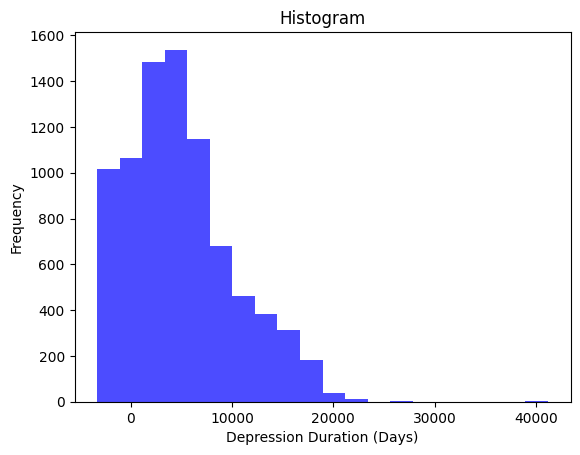

In [38]:
#check depression duration variable with histogram
plt.hist(pdf_rename['dep_dur'], bins=20, color='blue', alpha=0.7) 
plt.xlabel('Depression Duration (Days)')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

In [39]:
#fill empty rows in white_yes with 0; some 0 variables did not convert correctly and need manual imput
pdf_rename['white_yes'].fillna(0, inplace=True)

In [40]:
#calculate sum values of time spent in exercise for the 4 divided times per day (0:00-5:59; 6:00-11:59,etc)
for index, row in pdf_rename.iterrows():
    pdf_rename.at[index, 'pa_time_a'] = row['pa_time_1'] + row['pa_time_2'] + row['pa_time_3'] + row['pa_time_4'] + row['pa_time_5'] + row['pa_time_6']

for index, row in pdf_rename.iterrows():
    pdf_rename.at[index, 'pa_time_b'] = row['pa_time_7'] + row['pa_time_8'] + row['pa_time_9'] + row['pa_time_10'] + row['pa_time_11'] + row['pa_time_12']

for index, row in pdf_rename.iterrows():
    pdf_rename.at[index, 'pa_time_c'] = row['pa_time_13'] + row['pa_time_14'] + row['pa_time_15'] + row['pa_time_16'] + row['pa_time_17'] + row['pa_time_18']

for index, row in pdf_rename.iterrows():
    pdf_rename.at[index, 'pa_time_d'] = row['pa_time_19'] + row['pa_time_20'] + row['pa_time_21'] + row['pa_time_22'] + row['pa_time_23'] + row['pa_time_24']
   

In [41]:
#check pa types are in object non-array format
pdf_rename['pa_sleep_day_hour'].head(5)
#convert pa types to array for iterating
def convert_patypes_array(x):
    if pd.notna(x):
        return np.array(x.split(','))
    else:
        return np.array([])

pdf_rename['pa_sleep_day_hour_array'] = pdf_rename['pa_sleep_day_hour'].apply(convert_patypes_array)
pdf_rename['pa_sed_day_hour_array'] = pdf_rename['pa_sed_day_hour'].apply(convert_patypes_array)
pdf_rename['pa_light_day_hour_array'] = pdf_rename['pa_light_day_hour'].apply(convert_patypes_array)
pdf_rename['pa_mv_day_hour_array'] = pdf_rename['pa_mv_day_hour'].apply(convert_patypes_array)
#check array conversion successful
pdf_rename['pa_sleep_day_hour_array'].head(5)

0    [0.96, 0.97, 0.95, 0.96, 1, 1, 0.95, 0.57, 0.1...
1    [0.98, 1, 1, 1, 1, 1, 1, 0.44, 0.02, 0.14, 0, ...
2    [1, 0.99, 1, 1, 1, 0.85, 0.34, 0.47, 0.1, 0, 0...
3    [0.47, 0.5, 0.45, 0.4, 0.51, 0.44, 0.4, 0.43, ...
4    [0.73, 1, 1, 1, 1, 0.98, 0.88, 0.84, 0.66, 0.2...
Name: pa_sleep_day_hour_array, dtype: object

In [42]:
#convert all values in arrays to numeric
def array_to_numeric(arr):
    return [pd.to_numeric(val, errors='coerce') for val in arr]

pdf_rename['pa_sleep_day_hour_array'] = pdf_rename['pa_sleep_day_hour_array'].apply(array_to_numeric)
pdf_rename['pa_sed_day_hour_array'] = pdf_rename['pa_sed_day_hour_array'].apply(array_to_numeric)
pdf_rename['pa_light_day_hour_array'] = pdf_rename['pa_light_day_hour_array'].apply(array_to_numeric)
pdf_rename['pa_mv_day_hour_array'] = pdf_rename['pa_mv_day_hour_array'].apply(array_to_numeric)

In [43]:
#convert values in arrays from % per hour per day to total minutes per hour per day
def array_perc_to_min(arr):
    return [x * 60 for x in arr]
pdf_rename['pa_sleep_day_hour_array_clean'] = pdf_rename['pa_sleep_day_hour_array'].apply(array_perc_to_min)
pdf_rename['pa_sed_day_hour_array_clean'] = pdf_rename['pa_sed_day_hour_array'].apply(array_perc_to_min)
pdf_rename['pa_light_day_hour_array_clean'] = pdf_rename['pa_light_day_hour_array'].apply(array_perc_to_min)
pdf_rename['pa_mv_day_hour_array_clean'] = pdf_rename['pa_mv_day_hour_array'].apply(array_perc_to_min)
#check conversion to min is successful
pdf_rename['pa_sleep_day_hour_array_clean'].head(5)

0    [57.599999999999994, 58.199999999999996, 57.0,...
1    [58.8, 60, 60, 60, 60, 60, 60, 26.4, 1.2, 8.4,...
2    [60, 59.4, 60, 60, 60, 51.0, 20.40000000000000...
3    [28.2, 30.0, 27.0, 24.0, 30.6, 26.4, 24.0, 25....
4    [43.8, 60, 60, 60, 60, 58.8, 52.8, 50.4, 39.6,...
Name: pa_sleep_day_hour_array_clean, dtype: object

In [44]:
#create variables stratified by time of day (4 groups) consisting of 6 hours each
def create_pa_timeepochs(arr):
    sums = []
    for i in range(0, len(arr), 6):
        block = arr[i:i+6]
        sum_block = sum(block)
        sums.append(sum_block)
    return sums

pdf_rename[['pa_sleep_day_1', 'pa_sleep_day_2', 'pa_sleep_day_3', 'pa_sleep_day_4']] = pdf_rename['pa_sleep_day_hour_array_clean'].apply(create_pa_timeepochs).apply(pd.Series)
pdf_rename[['pa_sed_day_1', 'pa_sed_day_2', 'pa_sed_day_3', 'pa_sed_day_4']] = pdf_rename['pa_sed_day_hour_array_clean'].apply(create_pa_timeepochs).apply(pd.Series)
pdf_rename[['pa_light_day_1', 'pa_light_day_2', 'pa_light_day_3', 'pa_light_day_4']] = pdf_rename['pa_light_day_hour_array_clean'].apply(create_pa_timeepochs).apply(pd.Series)
pdf_rename[['pa_mv_day_1', 'pa_mv_day_2', 'pa_mv_day_3', 'pa_mv_day_4']] = pdf_rename['pa_mv_day_hour_array_clean'].apply(create_pa_timeepochs).apply(pd.Series)
#check conversion successful
pdf_rename['pa_mv_day_1'].head(5)

/tmp/ipykernel_2564/997299406.py:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pdf_rename[['pa_sleep_day_1', 'pa_sleep_day_2', 'pa_sleep_day_3', 'pa_sleep_day_4']] = pdf_rename['pa_sleep_day_hour_array_clean'].apply(create_pa_timeepochs).apply(pd.Series)
/tmp/ipykernel_2564/997299406.py:11: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pdf_rename[['pa_sed_day_1', 'pa_sed_day_2', 'pa_sed_day_3', 'pa_sed_day_4']] = pdf_rename['pa_sed_day_hour_array_clean'].apply(create_pa_timeepochs).apply(pd.Series)
/tmp/ipykernel_2564/997299406.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pdf_rename[['pa_light_day_1', 'pa_light_day_2', 'pa_light_

0     0.0
1     0.0
2     0.0
3    10.8
4     0.0
Name: pa_mv_day_1, dtype: float64

In [45]:
#check creation successful
pdf_rename['pa_sleep_day_2'].head(5)

0    105.6
1     96.0
2     54.6
3    144.0
4    166.2
Name: pa_sleep_day_2, dtype: float64

In [46]:
#check creation successful
pdf_rename['pa_sed_day_3'].head(5)

0    229.8
1    162.0
2    133.8
3    165.0
4    127.2
Name: pa_sed_day_3, dtype: float64

In [47]:
#check creation successful
pdf_rename['pa_sleep_day_4'].head(5)

0    109.2
1      9.0
2    199.2
3     70.2
4     75.6
Name: pa_sleep_day_4, dtype: float64

In [48]:
#

In [49]:
#calculate baseline data

In [50]:
#create comorbidity covariate in multiple steps

In [51]:
#convert comorbidity diagnosis dates to datetime format
pdf_rename["i10_date"] = pd.to_datetime(pdf_rename["i10_date"])
pdf_rename["i15_date"] = pd.to_datetime(pdf_rename["i15_date"])
pdf_rename["e78_date"] = pd.to_datetime(pdf_rename["e78_date"])
pdf_rename["e10_date"] = pd.to_datetime(pdf_rename["e10_date"])
pdf_rename["e11_date"] = pd.to_datetime(pdf_rename["e11_date"])
pdf_rename["i50_date"] = pd.to_datetime(pdf_rename["i50_date"])
pdf_rename["i25_date"] = pd.to_datetime(pdf_rename["i25_date"])

In [52]:
#create hypertension category
#prep htn cases
pdf_rename['i10_time'] = (pdf_rename['date_i0'] - pdf_rename['i10_date']).dt.days
pdf_rename['i15_time'] = (pdf_rename['date_i0'] - pdf_rename['i15_date']).dt.days

# check for htn; if yes, return 1
def check_htn_criteria(row):
    if row['i10_time'] > 0 or row['i15_time'] > 0 or '1065' in row['sr_illness'] or '1072' in row['sr_illness']:
        return 1
    else:
        return 0

pdf_rename['htn_yes'] = pdf_rename.apply(check_htn_criteria, axis=1)

In [53]:
#create heart failure category
#prep  cases
pdf_rename['i50_time'] = (pdf_rename['date_i0'] - pdf_rename['i50_date']).dt.days

# check for htn; if yes, return 1
def check_htn_criteria(row):
    if row['i50_time'] > 0  or '1076' in row['sr_illness']:
        return 1
    else:
        return 0

pdf_rename['hf_yes'] = pdf_rename.apply(check_htn_criteria, axis=1)

In [54]:
#create cad category
#prep  cases
pdf_rename['i25_time'] = (pdf_rename['date_i0'] - pdf_rename['i25_date']).dt.days

# check for htn; if yes, return 1
def check_htn_criteria(row):
    if row['i25_time'] > 0:
        return 1
    else:
        return 0

pdf_rename['cad_yes'] = pdf_rename.apply(check_htn_criteria, axis=1)

In [55]:
#create cancer covariate
pdf_rename['cancer_yes'] = pdf_rename['p134_i0'].apply(lambda x: 1 if x > 0 else 0)

In [56]:
#create hyperlipidemia category
#prep hchol cases
pdf_rename['e78_time'] = (pdf_rename['date_i0'] - pdf_rename['e78_date']).dt.days
def check_hchol_criteria(row):
    if row['e78_time'] > 0 or '1473' in row['sr_illness']:
        return 1
    else:
        return 0
    
pdf_rename['hchol_yes'] = pdf_rename.apply(check_hchol_criteria, axis=1)

In [57]:
#create diabetes category
#prep diabetes cases
pdf_rename['e10_date'] = pd.to_datetime(pdf_rename['e10_date'])
pdf_rename['e11_date'] = pd.to_datetime(pdf_rename['e11_date'])
pdf_rename['date_i0'] = pd.to_datetime(pdf_rename['date_i0'])
pdf_rename['e10_time'] = (pdf_rename['date_i0'] - pdf_rename['e10_date']).dt.days
pdf_rename['e11_time'] = (pdf_rename['date_i0'] - pdf_rename['e11_date']).dt.days

def check_diab_criteria(row):
    if row['e10_time'] > 0 or row['e11_time'] > 0 or '1222' in row['sr_illness'] or '1223' in row['sr_illness']:
        return 1
    else:
        return 0

pdf_rename['diab_yes'] = pdf_rename.apply(check_diab_criteria, axis=1)

In [58]:
#create comorbidity covariate for analysis and filter covariate for baseline characteristics table considering set of comorbidities created above
pdf_rename['comorb_sum'] = pdf_rename[['htn_yes', 'hf_yes', 'cad_yes', 'cancer_yes', 'hchol_yes', 'diab_yes']].sum(axis=1)
pdf_rename['comorb_sum_filter'] = pdf_rename['comorb_sum'].apply(lambda x: 0 if x == 0 else (1 if x == 1 else 2))

In [59]:
#prep clean cevd endpoint variable as first day in px chart with CeVD diagnosis after accelerometer study

In [60]:
#if assessment date - event date < 0, then copy absolute value to corresponding column
pdf_rename.loc[pdf_rename['f01_time'] < 0, 'f01_t2e'] = abs(pdf_rename['f01_time'])
pdf_rename.loc[pdf_rename['g45_time'] < 0, 'g45_t2e'] = abs(pdf_rename['g45_time'])
pdf_rename.loc[pdf_rename['g46_time'] < 0, 'g46_t2e'] = abs(pdf_rename['g46_time'])
pdf_rename.loc[pdf_rename['h34_time'] < 0, 'h34_t2e'] = abs(pdf_rename['h34_time'])
pdf_rename.loc[pdf_rename['i60_time'] < 0, 'i60_t2e'] = abs(pdf_rename['i60_time'])
pdf_rename.loc[pdf_rename['i61_time'] < 0, 'i61_t2e'] = abs(pdf_rename['i61_time'])
pdf_rename.loc[pdf_rename['i62_time'] < 0, 'i62_t2e'] = abs(pdf_rename['i62_time'])
pdf_rename.loc[pdf_rename['i63_time'] < 0, 'i63_t2e'] = abs(pdf_rename['i63_time'])
pdf_rename.loc[pdf_rename['i64_time'] < 0, 'i64_t2e'] = abs(pdf_rename['i64_time'])
pdf_rename.loc[pdf_rename['i65_time'] < 0, 'i65_t2e'] = abs(pdf_rename['i65_time'])
pdf_rename.loc[pdf_rename['i66_time'] < 0, 'i66_t2e'] = abs(pdf_rename['i66_time'])
pdf_rename.loc[pdf_rename['i67_time'] < 0, 'i67_t2e'] = abs(pdf_rename['i67_time'])
pdf_rename.loc[pdf_rename['i68_time'] < 0, 'i68_t2e'] = abs(pdf_rename['i68_time'])
pdf_rename.loc[pdf_rename['i69_time'] < 0, 'i69_t2e'] = abs(pdf_rename['i69_time'])

In [61]:
#if there is a time-to-event in XXX_t2e, then place 1 in outcome column for each CeVD
pdf_rename.loc[pdf_rename['f01_t2e'].notna(), 'f01_event'] = 1
pdf_rename.loc[pdf_rename['g45_t2e'].notna(), 'g45_event'] = 1
pdf_rename.loc[pdf_rename['g46_t2e'].notna(), 'g46_event'] = 1
pdf_rename.loc[pdf_rename['h34_t2e'].notna(), 'h34_event'] = 1
pdf_rename.loc[pdf_rename['i60_t2e'].notna(), 'i60_event'] = 1
pdf_rename.loc[pdf_rename['i61_t2e'].notna(), 'i61_event'] = 1
pdf_rename.loc[pdf_rename['i62_t2e'].notna(), 'i62_event'] = 1
pdf_rename.loc[pdf_rename['i63_t2e'].notna(), 'i63_event'] = 1
pdf_rename.loc[pdf_rename['i64_t2e'].notna(), 'i64_event'] = 1
pdf_rename.loc[pdf_rename['i65_t2e'].notna(), 'i65_event'] = 1
pdf_rename.loc[pdf_rename['i66_t2e'].notna(), 'i66_event'] = 1
pdf_rename.loc[pdf_rename['i67_t2e'].notna(), 'i67_event'] = 1
pdf_rename.loc[pdf_rename['i68_t2e'].notna(), 'i68_event'] = 1
pdf_rename.loc[pdf_rename['i69_t2e'].notna(), 'i69_event'] = 1

In [62]:
#create composite cevd outcome value
pdf_rename.loc[(pdf_rename['f01_event'].notna()) | (pdf_rename['g45_event'].notna()) | (pdf_rename['g46_event'].notna()) | (pdf_rename['h34_event'].notna()) | (pdf_rename['i60_event'].notna()) | (pdf_rename['i61_event'].notna()) | (pdf_rename['i62_event'].notna()) | (pdf_rename['i63_event'].notna()) | (pdf_rename['i64_event'].notna()) | (pdf_rename['i65_event'].notna()) | (pdf_rename['i66_event'].notna()) | (pdf_rename['i67_event'].notna()) | (pdf_rename['i68_event'].notna()) | (pdf_rename['i69_event'].notna()), 'cevd_event'] = 1
pdf_rename['cevd_event'] = pdf_rename['cevd_event'].fillna(0)

#check number of future cevd_events 
sum_cevdevents = pdf_rename['cevd_event'].sum()
print('Number of CeVD events (total)', sum_cevdevents)

Number of CeVD events (total) 2163.0


In [63]:
#create cevd time-to-event value for earliest cevd event
pdf_rename['cevd_t2e'] = pdf_rename[['f01_t2e', 'g45_t2e', 'g46_t2e', 'h34_t2e', 'i60_t2e', 'i61_t2e', 'i62_t2e', 'i63_t2e', 'i64_t2e', 'i65_t2e', 'i66_t2e', 'i67_t2e', 'i68_t2e', 'i69_t2e']].min(axis=1)

In [64]:
#convert all t2e columns to numeric for filtering
def convert_t2e_to_numeric(df):
    df['f01_t2e'] = pd.to_numeric(df['f01_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['g45_t2e'] = pd.to_numeric(df['g45_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['g46_t2e'] = pd.to_numeric(df['g46_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['h34_t2e'] = pd.to_numeric(df['h34_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['i60_t2e'] = pd.to_numeric(df['i60_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['i61_t2e'] = pd.to_numeric(df['i61_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['i62_t2e'] = pd.to_numeric(df['i62_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['i63_t2e'] = pd.to_numeric(df['i63_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['i64_t2e'] = pd.to_numeric(df['i64_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['i65_t2e'] = pd.to_numeric(df['i65_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['i66_t2e'] = pd.to_numeric(df['i66_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['i67_t2e'] = pd.to_numeric(df['i67_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['i68_t2e'] = pd.to_numeric(df['i68_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['i69_t2e'] = pd.to_numeric(df['i69_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['cevd_t2e'] = pd.to_numeric(df['cevd_t2e'], errors='coerce').astype(pd.Int64Dtype())
    return df

pdf_rename = convert_t2e_to_numeric(pdf_rename)

In [65]:
#clean all cevd types to only have t2e for the initial CeVD diagnosis after accelerometer study commencement
def check_cevd_types(df):
    for index, row in df.iterrows():
        if pd.notna(row['f01_t2e']):
            if row['f01_t2e'] != row['cevd_t2e']:
                df.at[index, 'f01_t2e'] = None
        if pd.notna(row['g45_t2e']):
            if row['g45_t2e'] != row['cevd_t2e']:
                 df.at[index, 'g45_t2e'] = None
        if pd.notna(row['g46_t2e']):
            if row['g46_t2e'] != row['cevd_t2e']:
                 df.at[index, 'g46_t2e'] = None
        if pd.notna(row['h34_t2e']):
            if row['h34_t2e'] != row['cevd_t2e']:
                 df.at[index, 'h34_t2e'] = None
        if pd.notna(row['i60_t2e']):
            if row['i60_t2e'] != row['cevd_t2e']:
                 df.at[index, 'i60_t2e'] = None
        if pd.notna(row['i61_t2e']):
            if row['i61_t2e'] != row['cevd_t2e']:
                 df.at[index, 'i61_t2e'] = None
        if pd.notna(row['i62_t2e']):
            if row['i62_t2e'] != row['cevd_t2e']:
                 df.at[index, 'i62_t2e'] = None
        if pd.notna(row['i63_t2e']):
            if row['i63_t2e'] != row['cevd_t2e']:
                 df.at[index, 'i63_t2e'] = None
        if pd.notna(row['i64_t2e']):
            if row['i64_t2e'] != row['cevd_t2e']:
                 df.at[index, 'i64_t2e'] = None
        if pd.notna(row['i65_t2e']):
            if row['i65_t2e'] != row['cevd_t2e']:
                 df.at[index, 'i65_t2e'] = None
        if pd.notna(row['i66_t2e']):
            if row['i66_t2e'] != row['cevd_t2e']:
                 df.at[index, 'i66_t2e'] = None
        if pd.notna(row['i67_t2e']):
            if row['i67_t2e'] != row['cevd_t2e']:
                 df.at[index, 'i67_t2e'] = None
        if pd.notna(row['i68_t2e']):
            if row['i68_t2e'] != row['cevd_t2e']:
                 df.at[index, 'i68_t2e'] = None
        if pd.notna(row['i69_t2e']):
            if row['i69_t2e'] != row['cevd_t2e']:
                 df.at[index, 'i69_t2e'] = None
    return df

cevd_df_first = check_cevd_types(pdf_rename)

In [66]:
#get the number of missing BMI values for imputation
missing_bmi = cevd_df_first['bmi'].isna().sum()
print('number of rows with missing BMI data:', missing_bmi)

number of rows with missing BMI data: 142


In [67]:
#USE MUTIPLE CHAIN IMPUTATION FOR MISSING BMI DATA
cols_to_impute = ['bmi']
# create an instance of the IterativeImputer class with MICE algorithm
imputer = IterativeImputer(max_iter=10, sample_posterior=True)
# impute the selected columns using multiple chains
cevd_df_first[cols_to_impute] = imputer.fit_transform(cevd_df_first[cols_to_impute])

In [68]:
#create a value with the day of intitial CeVD diagnosis after accelerometer study commencement
def find_firstday_cevd(row):
    dates = [row['f01_date'], row['g45_date'], row['g46_date'], row['h34_date'], row['i60_date'], row['i61_date'], row['i62_date'], row['i63_date'], row['i64_date'], row['i65_date'], row['i66_date'], row['i67_date'], row['i68_date'], row['i69_date']]
    non_empty_dates = [date for date in dates if not pd.isnull(date)]
    return min(non_empty_dates) if non_empty_dates else pd.NaT

cevd_df_first['cevd_day'] = cevd_df_first.apply(find_firstday_cevd, axis=1)

In [69]:
print('confirming the df length is 76,505 (complete) after wrangling', len(cevd_df_first))

confirming the df length is 76,505 (complete) after wrangling 76505


In [70]:
#check the number of px with a future CeVD in cohort
total_futurecevd = cevd_df_first[cevd_df_first['cevd_event']==1]
print('Number of patients in cohort with a future CeVD:', len(total_futurecevd))

Number of patients in cohort with a future CeVD: 2163


In [71]:
#create screen use covariate in multiple steps
screen_column = ['computer', 'tv', 'mobile phone']
cevd_df_first['tv'] = cevd_df_first['tv'].replace(-10, 0.5)
cevd_df_first['computer'] = cevd_df_first['computer'].replace(-10, 0.5)
cevd_df_first[screen_column] = cevd_df_first[screen_column].astype(int)

In [72]:
#reorder mobile phone use per week values 
#convert to hours or percentage of hours tied to 
cevd_df_first['mobile phone_filter'] = np.where(cevd_df_first['mobile phone'].isin([5]), 6, 
                    np.where(cevd_df_first['mobile phone'].isin([4]), 4,
                    np.where(cevd_df_first['mobile phone'].isin([3]), 2,
                    np.where(cevd_df_first['mobile phone'].isin([2]), 0.742, 
                    np.where(cevd_df_first['mobile phone'].isin([1]), 0.2, 
                             np.where(cevd_df_first['mobile phone'].isin([0]), 0.083, np.nan))))))

In [73]:
#screentime per day
cevd_df_first['full_screen_time'] = (cevd_df_first['computer']*1) + (cevd_df_first['tv']*1) + (cevd_df_first['mobile phone']/7)
cevd_df_first['full_screen_time'].head(4)

0    3.000000
1    0.000000
2    7.142857
3    3.142857
Name: full_screen_time, dtype: float64

In [74]:
total_futurecevd = cevd_df_first[cevd_df_first['cevd_event']==0]
print('number of non-future CeVD px:', len(total_futurecevd))

number of non-future CeVD px: 74342


In [75]:
#screen time per day filter; greater than 2 = 0
def assign_value(x):
    if x <= 2:
        return 1
    else:
        return 0

cevd_df_first['full_screen_time_filter'] = cevd_df_first['full_screen_time'].apply(assign_value)

In [76]:
#

In [77]:
#get baseline characteristics table

In [78]:
#

In [79]:
cevd_df_first_onlycevd = cevd_df_first
len(cevd_df_first_onlycevd)

76505

In [80]:
len(cevd_df_first_onlycevd[cevd_df_first_onlycevd['cevd_event'] == 1])

2163

In [81]:
subset = cevd_df_first_onlycevd[cevd_df_first_onlycevd['cevd_event'] == 1]
mean_age = subset['age_i0'].mean()
std_dev_age = subset['age_i0'].std()

print("Mean Age with exp cohort:", mean_age)
print("Standard Deviation of Age with exp cohort:", std_dev_age)
print('P-value for tdi:')
stats.mannwhitneyu(x=cevd_df_first_onlycevd['age_i0'], y=cevd_df_first_onlycevd['dep_diag_yes'], alternative = 'two-sided')
subset = cevd_df_first_onlycevd[cevd_df_first_onlycevd['cevd_event'] == 0]
mean_age = subset['age_i0'].mean()
std_dev_age = subset['age_i0'].std()

print("Mean Age with control cohort:", mean_age)
print("Standard Deviation of Age with control cohort:", std_dev_age)
print('P-value for tdi:')
stats.mannwhitneyu(x=cevd_df_first_onlycevd['age_i0'], y=cevd_df_first_onlycevd['cevd_event'], alternative = 'two-sided')

Mean Age with exp cohort: 60.562644475265834
Standard Deviation of Age with exp cohort: 6.533209183525972
P-value for tdi:
Mean Age with control cohort: 55.169433160259345
Standard Deviation of Age with control cohort: 7.784338581110335
P-value for tdi:


MannwhitneyuResult(statistic=5853015025.0, pvalue=0.0)

In [82]:
#get male/female data
percent_male_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 1, 'male'].mean() * 100
male_sum_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 1, 'male'].sum()
print('exp Cohort Percent male:', percent_male_d)
print('exp Cohort Total male:', male_sum_d)
percent_male_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 0, 'male'].mean() * 100
male_sum_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 0, 'male'].sum()
print('Control Cohort Percent male:', percent_male_c)
print('Control Cohort Total male:', male_sum_c)
perc_men_total = ((male_sum_d+male_sum_c)/76505)*100
print('% of men in total 76,505 cohort', perc_men_total)
data = pd.crosstab(cevd_df_first_onlycevd['male'], cevd_df_first_onlycevd['cevd_event']).to_numpy()
# chi-square test for independence for male data
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('MALE - Chi-square test statistic:', chi2_stat)
print('MALE - P-value:', p_val)

exp Cohort Percent male: 53.07443365695793
exp Cohort Total male: 1148
Control Cohort Percent male: 42.313900621452206
Control Cohort Total male: 31457
% of men in total 76,505 cohort 42.618129534017385
MALE - Chi-square test statistic: 99.0779667583258
MALE - P-value: 2.4275405775932333e-23


In [83]:
#get white/ethnicity data
percent_male_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 1, 'white_yes'].mean() * 100
male_sum_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 1, 'white_yes'].sum()
print('exp Cohort Percent white:', percent_male_d)
print('exp Cohort Total white:', male_sum_d)
percent_male_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 0, 'white_yes'].mean() * 100
male_sum_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 0, 'white_yes'].sum()
print('Control Cohort Percent white:', percent_male_c)
print('Control Cohort Total white:', male_sum_c)
perc_men_total = ((male_sum_d+male_sum_c)/76505)*100
print('% of white in total 76505 cohort', perc_men_total)
data = pd.crosstab(cevd_df_first_onlycevd['white_yes'], cevd_df_first_onlycevd['cevd_event']).to_numpy()
# chi-square test for independence for male data
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('white - Chi-square test statistic:', chi2_stat)
print('white - P-value:', p_val)

exp Cohort Percent white: 96.9486823855756
exp Cohort Total white: 2097.0
Control Cohort Percent white: 96.47305695300099
Control Cohort Total white: 71720.0
% of white in total 76505 cohort 96.48650415005555
white - Chi-square test statistic: 1.2657798165183423
white - P-value: 0.26055987895621857


In [84]:
#get smoking data
cevd_df_first_onlycevd['smok_stat'] = pd.to_numeric(cevd_df_first_onlycevd['smok_stat'], errors='coerce').astype(pd.Int64Dtype())
cevd_df_first_onlycevd['smok_filter'] = cevd_df_first_onlycevd['smok_stat'].apply(lambda x: 1 if (x > 0) else 0)
perc_alc_freq_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 1, 'smok_stat'].value_counts(normalize=True)
print('exp Percentages of smoke')
print(perc_alc_freq_d * 100)
perc_alc_freq_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 0, 'smok_stat'].value_counts(normalize=True)
# print the value counts as percentages
print('CONTROL Percentages of smoke')
print(perc_alc_freq_c * 100)

data = pd.crosstab(cevd_df_first_onlycevd['smok_stat'], cevd_df_first_onlycevd['cevd_event']).to_numpy()
# chi-square test for independence
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('smoke - Chi-square test statistic:', chi2_stat)
print('smoke - P-value:', p_val)

exp Percentages of smoke
0    47.434119
1    44.290337
2     8.275543
Name: smok_stat, dtype: Float64
CONTROL Percentages of smoke
0    56.814452
1    36.108794
2     7.076753
Name: smok_stat, dtype: Float64
smoke - Chi-square test statistic: 75.66819572483115
smoke - P-value: 3.705613079037276e-17


In [85]:
#get bmi data
cevd_df_first_onlycevd['bmi_filter'] = cevd_df_first_onlycevd['bmi'].apply(lambda x: 1 if (x > 18.4 and x < 26) else 0)
percent_male_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 1, 'bmi_filter'].mean() * 100
male_sum_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 1, 'bmi_filter'].sum()
print('exp Cohort Percent bmi:', percent_male_d)
print('exp Cohort Total bmi:', male_sum_d)
percent_male_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 0, 'bmi_filter'].mean() * 100
male_sum_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 0, 'bmi_filter'].sum()
print('Control Cohort Percent bmi:', percent_male_c)
print('Control Cohort Total bmi:', male_sum_c)
data = pd.crosstab(cevd_df_first_onlycevd['bmi_filter'], cevd_df_first_onlycevd['cevd_event']).to_numpy()
# chi-square test for independence for bmi data
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('bmi - Chi-square test statistic:', chi2_stat)
print('bmi - P-value:', p_val)

exp Cohort Percent bmi: 43.45815996301433
exp Cohort Total bmi: 940
Control Cohort Percent bmi: 49.0530252078233
Control Cohort Total bmi: 36467
bmi - Chi-square test statistic: 26.10666658931236
bmi - P-value: 3.2306664090705215e-07


In [86]:
#get disability assistance status data
percent_male_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 1, 'gov_assistance_filter'].mean() * 100
male_sum_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 1, 'gov_assistance_filter'].sum()
print('exp Cohort Percent disability $:', percent_male_d)
print('exp Cohort Total disability $:', male_sum_d)
percent_male_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 0, 'gov_assistance_filter'].mean() * 100
male_sum_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 0, 'gov_assistance_filter'].sum()
print('Control Cohort Percent disability $:', percent_male_c)
print('Control Cohort Total disability $:', male_sum_c)
data = pd.crosstab(cevd_df_first_onlycevd['gov_assistance_filter'], cevd_df_first_onlycevd['cevd_event']).to_numpy()
# chi-square test for independence for male data
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('disability $ - Chi-square test statistic:', chi2_stat)
print('disability $ - P-value:', p_val)

exp Cohort Percent disability $: 5.224225612575127
exp Cohort Total disability $: 113.0
Control Cohort Percent disability $: 2.395684808049286
Control Cohort Total disability $: 1781.0
disability $ - Chi-square test statistic: 68.48362446190052
disability $ - P-value: 1.2793558883069255e-16


In [87]:
#get screen use data
percent_male_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 1, 'full_screen_time_filter'].mean() * 100
male_sum_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 1, 'full_screen_time_filter'].sum()
print('exp Cohort Percent screen:', percent_male_d)
print('exp Cohort Total screen:', male_sum_d)
percent_male_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 0, 'full_screen_time_filter'].mean() * 100
male_sum_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 0, 'full_screen_time_filter'].sum()
print('Control Cohort Percent screen:', percent_male_c)
print('Control Cohort Total screen:', male_sum_c)
data = pd.crosstab(cevd_df_first_onlycevd['full_screen_time_filter'], cevd_df_first_onlycevd['cevd_event']).to_numpy()
# chi-square test for independence for male data
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('screen - Chi-square test statistic:', chi2_stat)
print('screen - P-value:', p_val)

exp Cohort Percent screen: 13.407304669440592
exp Cohort Total screen: 290
Control Cohort Percent screen: 17.47733448118157
Control Cohort Total screen: 12993
screen - Chi-square test statistic: 23.98389491325269
screen - P-value: 9.714490196618309e-07


In [88]:
# get the %s of each category for alcohol frequency 
perc_alc_freq_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 1, 'alc_freq_filter'].value_counts(normalize=True)
print('exp Percentages of alc freq')
print(perc_alc_freq_d * 100)
perc_alc_freq_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 0, 'alc_freq_filter'].value_counts(normalize=True)
# print the value counts as percentages
print('econtrol Percentages of alc freq')
print(perc_alc_freq_c * 100)
data = pd.crosstab(cevd_df_first_onlycevd['alc_freq_filter'], cevd_df_first_onlycevd['cevd_event']).to_numpy()
# chi-square test for independence
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('ALC FREQ - Chi-square test statistic:', chi2_stat)
print('ALC FREQ - P-value:', p_val)

exp Percentages of alc freq
2.0    44.983819
3.0    29.311142
1.0    25.705039
Name: alc_freq_filter, dtype: float64
econtrol Percentages of alc freq
2.0    52.606871
1.0    24.685911
3.0    22.707218
Name: alc_freq_filter, dtype: float64
ALC FREQ - Chi-square test statistic: 64.23548285408448
ALC FREQ - P-value: 1.1257504443053055e-14


In [89]:
subset = cevd_df_first_onlycevd[cevd_df_first_onlycevd['cevd_event'] == 1]
mean_age = subset['full_screen_time'].mean()
std_dev_age = subset['full_screen_time'].std()

print("Mean screen time with exp cohort:", mean_age)
print("Standard Deviation of screen time with exp cohort:", std_dev_age)
print('P-value:')
stats.mannwhitneyu(x=cevd_df_first_onlycevd['full_screen_time'], y=cevd_df_first_onlycevd['cevd_event'], alternative = 'two-sided')


Mean screen time with exp cohort: 4.095172049402286
Standard Deviation of screen time with exp cohort: 2.1654528679634337
P-value:


MannwhitneyuResult(statistic=5816505042.0, pvalue=0.0)

In [90]:
subset = cevd_df_first_onlycevd[cevd_df_first_onlycevd['cevd_event'] == 0]
mean_age = subset['full_screen_time'].mean()
std_dev_age = subset['full_screen_time'].std()

print("Mean screen with control cohort:", mean_age)
print("Standard Deviation of screenwith control cohort:", std_dev_age)
print('P-value:')
stats.mannwhitneyu(x=cevd_df_first_onlycevd['full_screen_time'], y=cevd_df_first_onlycevd['cevd_event'], alternative = 'two-sided')


Mean screen with control cohort: 3.7692459943811807
Standard Deviation of screenwith control cohort: 2.1503716063728913
P-value:


MannwhitneyuResult(statistic=5816505042.0, pvalue=0.0)

In [91]:
#get employment filter data
percent_male_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 1, 'employ_status_array_filter'].mean() * 100
male_sum_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 1, 'employ_status_array_filter'].sum()
print('exp Cohort Percent employment:', percent_male_d)
print('exp Cohort Total employment:', male_sum_d)
percent_male_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 0, 'employ_status_array_filter'].mean() * 100
male_sum_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 0, 'employ_status_array_filter'].sum()
print('Control Cohort Percent employment:', percent_male_c)
print('Control Cohort Total employment:', male_sum_c)
data = pd.crosstab(cevd_df_first_onlycevd['employ_status_array_filter'], cevd_df_first_onlycevd['cevd_event']).to_numpy()
# chi-square test for independence for male data
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('employment - Chi-square test statistic:', chi2_stat)
print('employment - P-value:', p_val)

exp Cohort Percent employment: 51.87239944521498
exp Cohort Total employment: 1122.0
Control Cohort Percent employment: 73.34346668101477
Control Cohort Total employment: 54525.0
employment - Chi-square test statistic: 469.3123170426571
employment - P-value: 1.2306235154399097e-102


In [92]:
# get comorbid filter data
perc_alc_freq_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 1, 'comorb_sum_filter'].value_counts(normalize=True)
print('exp Percentages of comorbid')
print(perc_alc_freq_d * 100)
perc_alc_freq_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 0, 'comorb_sum_filter'].value_counts(normalize=True)
print('CONTROL Percentages of comorbid')
print(perc_alc_freq_c * 100)
data = pd.crosstab(cevd_df_first_onlycevd['comorb_sum_filter'], cevd_df_first_onlycevd['cevd_event']).to_numpy()
# chi-square test for independence
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('comorbid - Chi-square test statistic:', chi2_stat)
print('comorbid - P-value:', p_val)

exp Percentages of comorbid
0    49.976884
1    33.009709
2    17.013407
Name: comorb_sum_filter, dtype: float64
CONTROL Percentages of comorbid
0    68.010008
1    23.611148
2     8.378844
Name: comorb_sum_filter, dtype: float64
comorbid - Chi-square test statistic: 360.74757205587184
comorbid - P-value: 4.6201922583704023e-79


In [93]:
# get the accelerometer wear month data 
perc_alc_freq_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 1, 'acc_wearmonth'].value_counts(normalize=True)
print('exp Percentages of acc wear month')
print(perc_alc_freq_d * 100)
perc_alc_freq_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 0, 'acc_wearmonth'].value_counts(normalize=True)
# print the value counts as percentages
print('CONTROL Percentages of acc wear month')
print(perc_alc_freq_c * 100)
data = pd.crosstab(cevd_df_first_onlycevd['acc_wearmonth'], cevd_df_first_onlycevd['cevd_event']).to_numpy()
# chi-square test for independence
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('acc wear month - Chi-square test statistic:', chi2_stat)
print('acc wear month - P-value:', p_val)

exp Percentages of acc wear month
4    30.097087
3    26.490985
2    21.729080
1    21.682848
Name: acc_wearmonth, dtype: float64
CONTROL Percentages of acc wear month
4    29.568750
3    26.269135
2    22.923785
1    21.238331
Name: acc_wearmonth, dtype: float64
acc wear month - Chi-square test statistic: 1.7437449650655716
acc wear month - P-value: 0.6272524783297337


In [94]:
#get male/female data
percent_male_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 1, 'dep_diag_yes'].mean() * 100
male_sum_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 1, 'dep_diag_yes'].sum()
print('exp Cohort Percent depressed:', percent_male_d)
print('exp Cohort Total depressed:', male_sum_d)
percent_male_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 0, 'dep_diag_yes'].mean() * 100
male_sum_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['cevd_event'] == 0, 'dep_diag_yes'].sum()
print('Control Cohort Percent depressed:', percent_male_c)
print('Control Cohort Total depressed:', male_sum_c)
data = pd.crosstab(cevd_df_first_onlycevd['dep_diag_yes'], cevd_df_first_onlycevd['cevd_event']).to_numpy()
# chi-square test for independence for male data
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('depressed - Chi-square test statistic:', chi2_stat)
print('depressed - P-value:', p_val)

exp Cohort Percent depressed: 9.939898289412854
exp Cohort Total depressed: 215
Control Cohort Percent depressed: 8.77296817411423
Control Cohort Total depressed: 6522
depressed - Chi-square test statistic: 3.4202491662271077
depressed - P-value: 0.06440129232624256


In [95]:
#export data for accelerometer study to .csv file to transfer to R
cevd_df_first.to_csv('cevd_first_model.csv', index=False)

In [96]:
#person year calculation if needed
#i69_days = cevd_df_first['i69_t2e'].sum()
#i69_personyears = i69_days/365
#print(i69_personyears)

In [97]:
#

In [98]:
#sensitivity analysis 1

In [99]:
#

In [100]:
#drop all px on disability assistance
cevd_df_noassist = cevd_df_first[cevd_df_first['gov_assistance_filter']==0]
len(cevd_df_noassist)

74611

In [101]:
#drop all px with comorbidities
cevd_df_noassist_nocomor = cevd_df_noassist[cevd_df_noassist['comorb_sum_filter']==0]
len(cevd_df_noassist_nocomor)

50749

In [102]:
cevd_df_noassist_nocomor.to_csv('cevd_first_model_sa.csv', index=False)

In [103]:
#

In [104]:
#sensitivity analysis 2

In [105]:
#

In [106]:
#filter time to event for cevd for sa

In [107]:
def filter_cevd_t2e(value):
    if pd.isna(value):
        return 0
    elif value < 1096:
        return 1
    elif 1096 <= value <= 1825:
        return 2
    else:
        return 3

cevd_df_first['cevd_t2e_filter'] = cevd_df_first['cevd_t2e'].apply(filter_cevd_t2e)

In [108]:
cevd_0 = cevd_df_first[cevd_df_first['cevd_t2e_filter']==0]
print('Number of px with no cevd:',len(cevd_0))

Number of px with no cevd: 74342


In [109]:
cevd_1 = cevd_df_first[cevd_df_first['cevd_t2e_filter']==1]
print('Number of px with cevd within 3 years of accelerometer study:',len(cevd_1))

Number of px with cevd within 3 years of accelerometer study: 636


In [110]:
cevd_2 = cevd_df_first[cevd_df_first['cevd_t2e_filter']==2]
print('Number of px with cevd between 3-5 years after accelerometer study:',len(cevd_2))

Number of px with cevd between 3-5 years after accelerometer study: 524


In [111]:
cevd_3 = cevd_df_first[cevd_df_first['cevd_t2e_filter']==3]
print('Number of px with cevd 5 or more years after accelerometer study:',len(cevd_3))

Number of px with cevd 5 or more years after accelerometer study: 1003


In [112]:
cevd_df_first.to_csv('cevd_first_model_sa_cevdt2e.csv', index=False)

In [113]:
mean_t2e_cevd = cevd_df_first['cevd_t2e'].mean()
std_t2e_cevd = cevd_df_first['cevd_t2e'].std()

print('mean years from end of study to CeVD:', (mean_t2e_cevd/365))
print('std:', (std_t2e_cevd/365))

mean years from end of study to CeVD: 4.507348368260724
std: 2.3530434375238425


In [114]:
#

In [115]:
#sensitvity analysis 3

In [116]:
#

In [117]:
def filter_dep_dur(value):
    if pd.isna(value):
        return 0
    elif value < 1896:
        return 1
    elif 1896 <= value <= 3650:
        return 2
    else:
        return 3

cevd_df_first['dep_dur_filter'] = cevd_df_first['dep_dur'].apply(filter_dep_dur)

In [118]:
dep_0 = cevd_df_first[cevd_df_first['dep_dur_filter']==0]
print('number of patients without depression diagnosis prior to accelerometer study:', len(dep_0))

number of patients without depression diagnosis prior to accelerometer study: 68186


In [119]:
dep_1 = cevd_df_first[cevd_df_first['dep_dur_filter']==1]
print('number of patients with depression diagnosis within 5 yrs before accelerometer study:', len(dep_1))

number of patients with depression diagnosis within 5 yrs before accelerometer study: 2450


In [120]:
dep_2 = cevd_df_first[cevd_df_first['dep_dur_filter']==2]
print('number of patients with depression diagnosis conferred between 5 and 10 yrs before accelerometer study:', len(dep_2))

number of patients with depression diagnosis conferred between 5 and 10 yrs before accelerometer study: 1326


In [121]:
dep_3 = cevd_df_first[cevd_df_first['dep_dur_filter']==3]
print('number of patients with depression diagnosis conferred 10 or more yrs before accelerometer study:', len(dep_3))

number of patients with depression diagnosis conferred 10 or more yrs before accelerometer study: 4543


In [122]:
mean_t2e_dep = cevd_df_first['dep_dur'].mean()
std_t2e_dep = cevd_df_first['dep_dur'].std()

print('mean years from dep diag to start of study:', (mean_t2e_dep/365))
print('std:', (std_t2e_dep/365))

mean years from dep diag to start of study: 13.539068348243912
std: 14.262918013429811


In [123]:
cevd_df_first.to_csv('cevd_first_model_sa_cevdt2eanddep.csv', index=False)

In [124]:
#to upload on RAP UKBB
#%%bash
#dx upload <insert file name here>.ipynb --dest /

In [125]:
#